# Step 1. Import packages

In [1]:
import numpy as np
from Bio.SeqIO.QualityIO import FastqGeneralIterator
from Bio.Seq import Seq
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import ListedColormap
from matplotlib.colors import TwoSlopeNorm
from scipy.integrate import simpson
from scipy.stats import pearsonr
from scipy.stats import linregress
from scipy.signal import find_peaks
from scipy import stats
import plotly.graph_objects as go
import plotly.express as px
import re

workdir = "./"
fig_dir = "./Figures/"

# Step 1-1. Helper functions

In [2]:
primer = "tattatggctcaccttcgggtgggcctttctgcgagac"
primer = primer.upper()
#refSeq = "GAATAGCGACGCCGAGCTCGTGGAGCTGTCCGGCGACACCCTGGAAGCCATCC"
len_amplicon = 30
# If you use have a single mutant library and know all the sequences:

TnsC_dict = workdir + "TnsB_dict_bar.txt"

def txt2list(file):
    with open(file) as f:
        lst = f.readlines()
    return lst

def read_dict(file):
    lst = txt2list(file)
    TnsC_dict = {} 
    read = False
    for line in lst:
        if line.startswith(">"):
            library_name = line[1:].strip()
            read = True 
        elif read:
            seq = line[0:len_amplicon] 
            TnsC_dict[seq] = library_name 
            read = False
    return TnsC_dict

In [3]:
def process_seq(seqs,primer,len_amplicon):
    """
    Processes a list of sequences to find the offset using a primer, translates the sequence if its size matches the reference,
    and identifies mutations.

    Parameters:
    seqs (list of str): List of DNA sequences to be processed.
    primer (str): The primer sequence used to find the offset.
    len_amplicon (int): The length of the reference sequence.

    Returns:
    list: A list of processed sequence information. Each element is a list containing:
        - Nucleotide sequence of barcodes or 0 if size does not match reference
        - Read number of barcodes (int)
        - Read number of variants (int)
        - Name of TnsC variants (str)
        - Name of barcodes (str)
    """
    rseqs=[]
    for seq in seqs:
        offset=seq.rfind(primer)+len(primer)
        wo_offset_seq=seq[offset:offset+len_amplicon]
        
        if len(wo_offset_seq) == len_amplicon:
            try:
                library_name = TnsC_DMS[wo_offset_seq]
                match = re.match(r'([A-Za-z0-9_*]+)_B(\d+)', library_name)

                if match:
                    main_library_name = match.group(1)
                    barcode_suffix = match.group(2)
                else:
                    main_library_name = library_name
                    barcode_suffix = None
                if main_library_name == 'TnsB_WT':
                    mut_aa = 'WT'
                else:
                    mut_aa = main_library_name[5:]
                barcode = library_name[5:]
                rseqs.append([wo_offset_seq, mut_aa, barcode])

            except KeyError:
                rseqs.append([0, 0])
                continue

        else:
            rseqs.append([0, 0])

    return rseqs
    
def generate_df(file, primer, len_amplicon, nc=20,nt_counts=10,aa_counts=0,batch_size=100000):
    """
    Generates a DataFrame from a FASTQ file containing DNA sequences, processes the sequences to find mutations, and filters the results.

    Parameters:
    file (str): Path to the FASTQ file.
    primer (str): The primer sequence used to find the offset.
    len_amplicon (int): The length of the reference sequence.
    nc (int): Number of CPU cores to use for parallel processing.
    nt_counts (int): Minimum number of reads for nucleotide sequences to be included in the final DataFrame.
    aa_counts (int): Minimum number of reads for amino acid sequences to be included in the final DataFrame.
    batch_size (int): Number of sequences to process in each batch.

    Returns:
    DataFrame: A DataFrame containing information about the processed sequences and their mutations.
    """
    print('Processing ',file)
    #Load file
    fastq_gen = FastqGeneralIterator(open(file))
    seqs=[i[1] for i in fastq_gen]
    #Translate and filter nucleotides sequences
    print('Linking Barcodes with variants')
    out=Parallel(n_jobs=nc)(delayed(process_seq)(seqs[i:i+batch_size], primer, len_amplicon) for i in tqdm(range(0,len(seqs),batch_size)))
    results=[]
    for i in range(len(out)):
        for j in out[i]:
            results.append(j)
            
    good_seqs=np.array([r[0]!=0 for r in results])
    print('Number of senquences with the right length: ',np.sum(good_seqs),'out of ',len(seqs))
    del seqs
    results=[results[i] for i in range(len(results)) if good_seqs[i]==True]
    results=np.array(results,dtype=object)
    #results[results=='']='WT'
    #Merge information into data frame
    d = {'Barcode_seq': results[:, 0],
        'AA_mut_list': results[:, 1],
        'Barcode_name': results[:, 2]}
    df = pd.DataFrame(data=d)
    df=df[np.array([not 'N' in i for i in df['Barcode_seq']])]
    #Remove duplicates while keeping reads
    counts=df['AA_mut_list'].value_counts()
    df['reads_AA']=df['AA_mut_list'].map(counts)
    counts=df['Barcode_name'].value_counts()
    df['reads_Bar']=df['Barcode_name'].map(counts)
    df = df.drop_duplicates(subset=['AA_mut_list', 'Barcode_name'])
    #Compute frequency of each variant
    df['freq_AA']=df['reads_AA']/np.sum(df['reads_Bar'])
    df['freq_Bar']=df['reads_Bar']/np.sum(df['reads_Bar'])
    #Filter for low reads
    df=df[(df['reads_AA']>aa_counts)*(df['reads_Bar']>nt_counts)]

    print(len(df),'variants with more than',nt_counts,'reads and with no X in AA sequence')
    
    return df

def create_df(data):
    """
    Creates a DataFrame from a numpy array with mutation and sequence data.

    Parameters:
    data (numpy.ndarray): A 2D numpy array where each row contains:
        - AA_mut_list (str): List of amino acid mutations.
        - Barcode_name (str): List of barcodes.
        - Barcode_seq (str): Barocde sequence.
        - reads_AA (int): Read count for each TnsC variants
        - reads_Bar (int): Read count for each barcodes.
        - freq_AA (float): Frequency of each TnsC variants.
        - freq_Bar (float): Frequency of each barcodes.

    Returns:
    DataFrame: A pandas DataFrame containing the provided data with appropriate column names.
    """
    df = {
            'Barcode_seq': pd.Series(data[:,0]),
            'AA_mut_list': pd.Series(data[:,1]),
            'Barcode_name': pd.Series(data[:,2]),       
            'reads_AA': pd.Series(data[:,3]),
            'reads_Bar': pd.Series(data[:,4]),
            'freq_AA': pd.Series(data[:,5]),
            'freq_Bar': pd.Series(data[:,6])
    }
    return pd.DataFrame(df)


# Step 2a. Process Fastq data 
### Skip this step if processed data file (./data_kan_ara_filter.npy) is present

In [ ]:
the=0
print('Counts thershole',the)
df_input_R1=generate_df(workdir+'TnsB_R1_input.fastq', primer, len_amplicon, nc=20, nt_counts=the)
df_input_R2=generate_df(workdir+'TnsB_R2_input.fastq', primer, len_amplicon, nc=20, nt_counts=the)
df_Kan_R1=generate_df(workdir+'TnsB_R1_Kan.fastq', primer, len_amplicon, nc=20, nt_counts=the)
df_Kan_R2=generate_df(workdir+'TnsB_R2_Kan.fastq', primer, len_amplicon, nc=20, nt_counts=the)
df_Ara_R1=generate_df(workdir+'TnsB_R1_Ara.fastq', primer, len_amplicon, nc=20, nt_counts=the)
df_Ara_R2=generate_df(workdir+'TnsB_R2_Ara.fastq', primer, len_amplicon, nc=20, nt_counts=the)

# Save processed data
with open(workdir + 'TnsB_data_kan_ara.npy', 'wb') as f:
    np.save(f, df_input_R1) 
    np.save(f, df_input_R2)
    np.save(f, df_Kan_R1)
    np.save(f, df_Kan_R2)
    np.save(f, df_Ara_R1)
    np.save(f, df_Ara_R2)

# Step 2b. Load processed data saved in data_kan_ara.npy 

In [4]:
# Load processed data
with open(workdir + 'TnsB_data_kan_ara.npy', 'rb') as f:
    df_input_R1=create_df(np.load(f,allow_pickle=True))
    df_input_R2=create_df(np.load(f,allow_pickle=True))
    df_Kan_R1=create_df(np.load(f,allow_pickle=True))
    df_Kan_R2=create_df(np.load(f,allow_pickle=True))
    df_Ara_R1=create_df(np.load(f,allow_pickle=True))
    df_Ara_R2=create_df(np.load(f,allow_pickle=True))

In [5]:
def merged_df_readBar(d1,d2,suffixes,the):
    d1 = d1[(d1['reads_Bar'] > the) & (d1['reads_AA'] > 50)]
    df12 = pd.merge(d1, d2, on=['Barcode_seq', 'AA_mut_list', 'Barcode_name'], suffixes=suffixes)
    #df12 = pd.merge(d1, d2, on=['Barcode_seq', 'AA_mut_list', 'Barcode_name'], how='left', suffixes=suffixes)
    #df12 = df12.replace(np.nan, 0)
    #Get relative change in frequency
    wt_d1=np.array(df12[df12['AA_mut_list']=='WT']['reads_Bar'+suffixes[0]],dtype=float)+0.5
    wt_d2=np.array(df12[df12['AA_mut_list']=='WT']['reads_Bar'+suffixes[1]],dtype=float)+0.5
    tr_d1=np.sum(df12['reads_Bar'+suffixes[0]])
    tr_d2=np.sum(df12['reads_Bar'+suffixes[1]]) 
    wt_rel_change=(wt_d2/tr_d2)/(wt_d1/tr_d1)
    indx = np.argmin(np.fabs(wt_rel_change-np.median(wt_rel_change)))
    #Select barcode closest to the median
    wt_barcode=df12[df12['AA_mut_list']=='WT'].iloc[indx]['Barcode_name']
    print('WT referece barcode:',wt_barcode)
    wt_sel=d2[d2['Barcode_name']==wt_barcode]['reads_Bar'].values[0]+0.5
    wt_inp=d1[d1['Barcode_name']==wt_barcode]['reads_Bar'].values[0]+0.5
    counts_sel=np.array(df12['reads_Bar'+suffixes[1]].values,dtype=float)+0.5
    counts_inp=np.array(df12['reads_Bar'+suffixes[0]].values,dtype=float)+0.5
    enrich=np.log2(counts_sel/wt_sel) - np.log2(counts_inp/wt_inp)
    df12['enrich'+suffixes[1]]=enrich
    s=1/wt_sel + 1/wt_inp + 1/(df12['reads_Bar'+suffixes[1]]+0.5).values + 1/(df12['reads_Bar'+suffixes[0]]+0.5).values
    df12['stderr'+suffixes[1]]=np.sqrt(np.array(s,dtype=float))
    return df12

def merged_df_readAA(d1,d2,suffixes,the):
    """
    Merges two DataFrames on nucleotide and amino acid mutation information, filters based on read counts, and calculates enrichment and standard error.

    This function calculates the score by combining the reads of all barcodes corresponding to each variant. (based on reads_AA)
    
    Parameters:
    d1 (DataFrame): First DataFrame containing mutation and sequence data.
    d2 (DataFrame): Second DataFrame containing mutation and sequence data.
    suffixes (tuple): Suffixes to apply to overlapping column names in the resulting DataFrame.
    the (int): Threshold for filtering sequences based on read counts.

    Returns:
    DataFrame: A merged DataFrame with calculated enrichment and standard error.
    """
    d1=d1[d1['reads_Bar']>the]
    df12=pd.merge(d1, d2, on=['Barcode_seq','AA_mut_list','Barcode_name'],how='left',suffixes=suffixes)
    df12=df12.replace(np.nan,0)
    wt_sel=d2[d2['AA_mut_list']=='WT']['reads_AA'].values[0]+0.5
    wt_inp=d1[d1['AA_mut_list']=='WT']['reads_AA'].values[0]+0.5
    counts_sel=np.array(df12['reads_AA'+suffixes[1]].values,dtype=float)+0.5
    counts_inp=np.array(df12['reads_AA'+suffixes[0]].values,dtype=float)+0.5
    enrich=np.log2(counts_sel/wt_sel) - np.log2(counts_inp/wt_inp)
    print(np.log2(counts_sel/wt_sel) - np.log2(counts_inp/wt_inp))
    df12['enrich'+suffixes[1]]=enrich
    
    s=1/wt_sel + 1/wt_inp + 1/(df12['reads_AA'+suffixes[1]]+0.5).values + 1/(df12['reads_AA'+suffixes[0]]+0.5).values
    
    df12['stderr'+suffixes[1]]=np.sqrt(np.array(s,dtype=float))
    return df12
    
def merged_df_replicates(d1,d2,suffixes):
    """
    Merges two DataFrames on nucleotide and amino acid mutation information.

    Parameters:
    d1 (DataFrame): First DataFrame containing mutation and sequence data.
    d2 (DataFrame): Second DataFrame containing mutation and sequence data.
    suffixes (tuple): Suffixes to apply to overlapping column names in the resulting DataFrame.

    Returns:
    DataFrame: A merged DataFrame containing columns from both input DataFrames.
    """
    df12=pd.merge(d1, d2, on=['Barcode_name','AA_mut_list','Barcode_seq'],suffixes=suffixes)
    return df12

def mut_in_context(df,suffixes,mutation,style):
    """
    Plots the enrichment score of a specific mutation in the context of wild-type synonymous mutations.

    Parameters:
    df (DataFrame): DataFrame containing mutation and sequence data.
    suffixes (tuple): Suffixes to apply to overlapping column names in the resulting DataFrame.
    mutation (str): The specific mutation to highlight in the plot.
    style (str): The style of the plot, specifying which column to use for the x-axis.
    """
    mut=mutation
    fig=plt.figure(figsize=(3,2))
    ax=fig.add_subplot(111)
    ax.set_title(mut+' '+style+' in\ncontext of WT syn mut')
    kernel = stats.gaussian_kde(df[df['AA_mut_list']=='WT']['enrich'+suffixes[1]])

    sub_df=df[df['AA_mut_list']==mut]
    ax.errorbar(sub_df[style].values[0],[0.4],xerr=sub_df['stderr'].values[0],capsize=5,color='k',barsabove=False)
    ax.scatter(sub_df['enrich'+suffixes[0]],np.zeros(len(sub_df))+0.4,c='k',s=5)
    ax.scatter(sub_df['enrich'+suffixes[1]],np.zeros(len(sub_df))+0.4,c='k',s=5)
    scatter=ax.scatter(sub_df[style].values[0],[0.4],c=sub_df['stderr'].values[0],
            cmap='RdBu_r',vmin=0,vmax=df['stderr'].max(),edgecolor='k')
    x=np.linspace(-5,5,50)
    ax.plot(x,kernel(x)/4,color='k')
    ax.plot(x,-kernel(x)/4,color='k')
    ax.fill_between(x,kernel(x)/4,-kernel(x)/4,edgecolor='gray',facecolor='gray')

    ax.set_xlabel('Score')
    ax.set_yticks([])
    ax.set_ylim([-0.3,0.7])
    ax.legend([f"P-value={sub_df['pvalues'].values[0]:.2e}"])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(scatter, cax=cax, orientation='vertical',label='stderr')

def score_n_error(df,mut,suffixes):
    """
    Calculates the score and error for a specific mutation using weighted averages and iterative refinement.

    Parameters:
    df (DataFrame): DataFrame containing mutation and sequence data.
    mut (str): The specific mutation to calculate the score and error for.
    suffixes (tuple): Suffixes to apply to overlapping column names in the resulting DataFrame.

    Returns:
    tuple: A tuple containing the calculated score (tmp_beta) and error (tmp_error).
    """
    sub_df=df[df['AA_mut_list']==mut]
    replicates=2*len(sub_df)
    scores=np.concatenate([sub_df['enrich'+suffixes[0]].values,sub_df['enrich'+suffixes[1]].values])
    errors=np.concatenate([sub_df['stderr'+suffixes[0]].values,sub_df['stderr'+suffixes[1]].values])
    error=np.sum([(i - np.mean(scores))**2 for i in scores ])/(replicates-1)
    tmp_error=error
    for _ in range(50):
        num=np.sum(scores*((tmp_error**2 + errors**2)**-1))
        den=np.sum(((tmp_error**2 + errors**2)**-1))
        tmp_beta=num/den
        num=np.sum(((scores-tmp_beta)**2) * ((tmp_error**2 + errors**2)**(-2)))
        den=np.sum(((tmp_error**2 + errors**2)**-1))-np.sum(((tmp_error**2 + errors**2)**(-2)))/np.sum(((tmp_error**2 + errors**2)**-1))
        tmp_error=np.sqrt(tmp_error*num/den)
    return tmp_beta, tmp_error  
    
def rep_score_n_error(df,mut,suffix):
    """
    Computes the enrichment score and error for a specific mutation, using weighted averages and iterative refinement.
    If there is only one biological replicate, returns the score and error directly.

    Parameters:
    df (DataFrame): DataFrame containing mutation and sequence data.
    mut (str): The specific mutation to calculate the score and error for.
    suffix (str): Suffix to apply to overlapping column names in the resulting DataFrame.

    Returns:
    tuple: A tuple containing the calculated score (tmp_beta) and error (tmp_error).
    """
    #Computes ENRICH2 UNLESS there are no biological replicates in the technical replcate
    sub_df=df[df['AA_mut_list']==mut]
    replicates=len(sub_df)
    if replicates!=1:
        scores=sub_df['enrich'+suffix].values
        errors=sub_df['stderr'+suffix].values
        error=np.sum([(i - np.mean(scores))**2 for i in scores ])/(replicates-1)
        tmp_error=error
        for _ in range(50):
            num=np.sum(scores*((tmp_error**2 + errors**2)**-1))
            den=np.sum(((tmp_error**2 + errors**2)**-1))
            tmp_beta=num/den
            num=np.sum(((scores-tmp_beta)**2) * ((tmp_error**2 + errors**2)**(-2)))
            den=np.sum(((tmp_error**2 + errors**2)**-1))-np.sum(((tmp_error**2 + errors**2)**(-2)))/np.sum(((tmp_error**2 + errors**2)**-1))
            tmp_error=np.sqrt(tmp_error*num/den)
    else:
        tmp_beta = sub_df['enrich'+suffix].values[0]
        tmp_error = sub_df['stderr'+suffix].values[0]
    return tmp_beta, tmp_error

def p_values(df,mut,suffixes):
    """
    Computes the p-value for the enrichment scores of a specific mutation compared to wild-type using the Mann-Whitney U test.

    Parameters:
    df (DataFrame): DataFrame containing mutation and sequence data.
    mut (str): The specific mutation to calculate the p-value for.
    suffixes (tuple): Suffixes to apply to overlapping column names in the resulting DataFrame.

    Returns:
    float: The p-value from the Mann-Whitney U test comparing the mutation to wild-type.
    """
    sub_df=df[df['AA_mut_list']==mut]
    wt_values=np.concatenate([df[df['AA_mut_list']=='WT']['enrich'+suffixes[0]],df[df['AA_mut_list']=='WT']['enrich'+suffixes[1]]])
    mut_values=np.concatenate([sub_df['enrich'+suffixes[0]],sub_df['enrich'+suffixes[1]]])
    _, p = stats.mannwhitneyu(wt_values,mut_values)
    return p

In [6]:
def score_n_error_barcode(df,mut,suffixes):
    """
    Calculates the score and error for a specific mutation using weighted averages and iterative refinement.

    Parameters:
    df (DataFrame): DataFrame containing mutation and sequence data.
    mut (str): The specific mutation to calculate the score and error for.
    suffixes (tuple): Suffixes to apply to overlapping column names in the resulting DataFrame.

    Returns:
    tuple: A tuple containing the calculated score (tmp_beta) and error (tmp_error).
    """
    sub_df=df[df['AA_mut_list']==mut]

    valid_1 = sub_df['reads_AA' + suffixes[0]] != 0
    enrich_1 = sub_df.loc[valid_1, 'enrich' + suffixes[0]].values
    stderr_1 = sub_df.loc[valid_1, 'stderr' + suffixes[0]].values

    valid_2 = sub_df['reads_AA' + suffixes[1]] != 0
    enrich_2 = sub_df.loc[valid_2, 'enrich' + suffixes[1]].values
    stderr_2 = sub_df.loc[valid_2, 'stderr' + suffixes[1]].values

    scores = np.concatenate([enrich_1, enrich_2])
    errors = np.concatenate([stderr_1, stderr_2])
    
    replicates = len(scores)
    error=np.sum([(i - np.mean(scores))**2 for i in scores ])/(replicates-1)
    tmp_error=error
    for _ in range(50):
        num=np.sum(scores*((tmp_error**2 + errors**2)**-1))
        den=np.sum(((tmp_error**2 + errors**2)**-1))
        tmp_beta=num/den
        num=np.sum(((scores-tmp_beta)**2) * ((tmp_error**2 + errors**2)**(-2)))
        den=np.sum(((tmp_error**2 + errors**2)**-1))-np.sum(((tmp_error**2 + errors**2)**(-2)))/np.sum(((tmp_error**2 + errors**2)**-1))
        tmp_error=np.sqrt(tmp_error*num/den)
    return tmp_beta, tmp_error  
  
def rep_score_n_error_barcode(df,mut,suffix):
    """
    Computes the enrichment score and error for a specific mutation, using weighted averages and iterative refinement.
    If there is only one biological replicate, returns the score and error directly.

    Parameters:
    df (DataFrame): DataFrame containing mutation and sequence data.
    mut (str): The specific mutation to calculate the score and error for.
    suffix (str): Suffix to apply to overlapping column names in the resulting DataFrame.

    Returns:
    tuple: A tuple containing the calculated score (tmp_beta) and error (tmp_error).
    """
    #Computes ENRICH2 UNLESS there are no biological replicates in the technical replcate
    sub_df=df[df['AA_mut_list']==mut]
    valid_rows = sub_df['reads_AA' + suffix] != 0
    filtered_df = sub_df[valid_rows]
    replicates=len(filtered_df)
    
    if replicates!=1:
        scores=filtered_df['enrich'+suffix].values
        errors=filtered_df['stderr'+suffix].values
        error=np.sum([(i - np.mean(scores))**2 for i in scores ])/(replicates-1)
        tmp_error=error
        for _ in range(50):
            num=np.sum(scores*((tmp_error**2 + errors**2)**-1))
            den=np.sum(((tmp_error**2 + errors**2)**-1))
            tmp_beta=num/den
            num=np.sum(((scores-tmp_beta)**2) * ((tmp_error**2 + errors**2)**(-2)))
            den=np.sum(((tmp_error**2 + errors**2)**-1))-np.sum(((tmp_error**2 + errors**2)**(-2)))/np.sum(((tmp_error**2 + errors**2)**-1))
            tmp_error=np.sqrt(tmp_error*num/den)
    else:
        tmp_beta = filtered_df['enrich'+suffix].values[0]
        tmp_error = filtered_df['stderr'+suffix].values[0]
    return tmp_beta, tmp_error

def p_values_barcodes(df,mut,suffixes):
    """
    Computes the p-value for the enrichment scores of a specific mutation compared to wild-type using the Mann-Whitney U test.

    Parameters:
    df (DataFrame): DataFrame containing mutation and sequence data.
    mut (str): The specific mutation to calculate the p-value for.
    suffixes (tuple): Suffixes to apply to overlapping column names in the resulting DataFrame.

    Returns:
    float: The p-value from the Mann-Whitney U test comparing the mutation to wild-type.
    """
    wt_r1 = df[(df['AA_mut_list'] == 'WT') & (df['reads_AA' + suffixes[0]] != 0)]
    wt_r2 = df[(df['AA_mut_list'] == 'WT') & (df['reads_AA' + suffixes[1]] != 0)]
    wt_values = np.concatenate([wt_r1['enrich' + suffixes[0]], wt_r2['enrich' + suffixes[1]]])
    
    sub_df=df[df['AA_mut_list']==mut]
    mut_r1 = sub_df[sub_df['reads_AA' + suffixes[0]] != 0]
    mut_r2 = sub_df[sub_df['reads_AA' + suffixes[1]] != 0]
    mut_values = np.concatenate([mut_r1['enrich' + suffixes[0]], mut_r2['enrich' + suffixes[1]]])
    _, p = stats.mannwhitneyu(wt_values,mut_values)
    return p

In [7]:
read_filter=10
df_Kan_input_R1=merged_df_readBar(df_input_R1,df_Kan_R1,['_input','_Kan'],the=read_filter)
df_Kan_input_R2=merged_df_readBar(df_input_R2,df_Kan_R2,['_input','_Kan'],the=read_filter)
df_Ara_input_R1=merged_df_readBar(df_input_R1,df_Ara_R1,['_input','_Ara'],the=read_filter)
df_Ara_input_R2=merged_df_readBar(df_input_R2,df_Ara_R2,['_input','_Ara'],the=read_filter)
df_Kan_Ara_R1=merged_df_readBar(df_Kan_R1,df_Ara_R1,['_Kan','_Ara'],the=read_filter)
df_Kan_Ara_R2=merged_df_readBar(df_Kan_R2,df_Ara_R2,['_Kan','_Ara'],the=read_filter)

WT referece barcode: WT_B31
WT referece barcode: WT_B950
WT referece barcode: WT_B1534
WT referece barcode: WT_B40
WT referece barcode: WT_B839
WT referece barcode: WT_B925


In [8]:
df_Kan_input=merged_df_replicates(df_Kan_input_R1,df_Kan_input_R2,['_R1','_R2'])
df_Ara_input=merged_df_replicates(df_Ara_input_R1,df_Ara_input_R2,['_R1','_R2'])
df_Kan_Ara=merged_df_replicates(df_Kan_Ara_R1,df_Kan_Ara_R2,['_R1','_R2'])

In [9]:
unique_count = df_Kan_input['AA_mut_list'].nunique()
print(f"Unique rows count: {unique_count}")

Unique rows count: 1898


# Step 3. Score Calculation
### Skip this step if processed cvs files are present

In [10]:
# Process Kanamycin input data for both replicates (R1 and R2)
for rep in ['R1', 'R2']:
    scores = []
    errors = []
    # Iterate over each row in the dataframe
    for i in range(len(df_Kan_input)):
        # Calculate the score and error for the current replicate
        s, e = rep_score_n_error(df_Kan_input, df_Kan_input['AA_mut_list'][i], '_Kan_' + rep)
        scores.append(s)
        errors.append(e)
    # Add the scores and errors to the dataframe
    df_Kan_input['activity_' + rep] = scores
    df_Kan_input['stderr_' + rep] = errors

In [11]:
# Process Arabinose input data for both replicates (R1 and R2)
for rep in ['R1', 'R2']:
    scores = []
    errors = []
    # Iterate over each row in the dataframe
    for i in range(len(df_Kan_Ara)):
        # Calculate the score and error for the current replicate
        s, e = rep_score_n_error(df_Kan_Ara, df_Kan_Ara['AA_mut_list'][i], '_Ara_' + rep)
        scores.append(s)
        errors.append(e)
    # Add the scores and errors to the dataframe
    df_Kan_Ara['specificity_' + rep] = scores
    df_Kan_Ara['stderr_' + rep] = errors

In [12]:
scores=[]
errors=[]
pvalue=[]
for i in range(len(df_Kan_input)):
    s,e= score_n_error(df_Kan_input,df_Kan_input['AA_mut_list'][i],['_Kan_R1','_Kan_R2'])
    p = p_values(df_Kan_input,df_Kan_input['AA_mut_list'][i],['_Kan_R1','_Kan_R2'])
    scores.append(s)
    errors.append(e)
    pvalue.append(p)
df_Kan_input['activity']=scores
df_Kan_input['stderr']=errors
df_Kan_input['pvalues']=pvalue

scores=[]
errors=[]
pvalue=[]
for i in range(len(df_Kan_Ara)):
    s,e= score_n_error(df_Kan_Ara,df_Kan_Ara['AA_mut_list'][i],['_Ara_R1','_Ara_R2'])
    p = p_values(df_Kan_Ara,df_Kan_Ara['AA_mut_list'][i],['_Ara_R1','_Ara_R2'])
    scores.append(s)
    errors.append(e)
    pvalue.append(p)
df_Kan_Ara['specificity']=scores
df_Kan_Ara['stderr']=errors
df_Kan_Ara['pvalues']=pvalue

In [13]:
#Save processed dataframes 
df_Kan_input.to_csv('activity_full_dataframe.csv')
df_Kan_Ara.to_csv('specificity_full_dataframe.csv')

In [14]:
df_Kan_input.drop_duplicates(subset='AA_mut_list')[['AA_mut_list','activity','stderr','activity_R1','stderr_R1','activity_R2','stderr_R2']].to_csv('activity_simple_dataframe.csv')
df_Kan_Ara.drop_duplicates(subset='AA_mut_list')[['AA_mut_list','specificity','stderr','specificity_R1','stderr_R1','specificity_R2','stderr_R2']].to_csv('specificity_simple_dataframe.csv')

# Step 4. Scatter plot between Replicates

In [10]:
df_Kan_input = pd.read_csv('TnsB_activity_full_dataframe.csv')
df_Kan_Ara = pd.read_csv('TnsB_specificity_full_dataframe.csv')

In [11]:
def replicate_scatter(df, data_type, the):
    """
    Plot a scatter between two repliacates with Pearson correlation

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        data_type (str) : activity or specificity
        the (float) : error thereshold
    Returns:
        fig
    """
    filtered_df = df[(df['stderr'] <= the)]
    df_unique = filtered_df.drop_duplicates(subset='AA_mut_list')
    x = df_unique[data_type+'_R1']
    y = df_unique[data_type+'_R2']
    names = df_unique['AA_mut_list']
    #Pearson
    pearson_corr, _ = pearsonr(x, y)
    #Number of dots
    num_dots = len(x)
    print(f"Number of total points: {num_dots}")
    
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(x, y, c='black', s=10, alpha=0.4)
    plt.axhline(y=0, linewidth=1, color='k')
    plt.axvline(x=0, linewidth=1, color='k')
    # regression line
    sns.regplot(x=x, y=y, scatter=False, color='red', line_kws={'label': f'Regression Line (r={pearson_corr:.2f})'})
    plt.text(0.05, 0.95, f'Pearson r = {pearson_corr:.2f}', transform=plt.gca().transAxes, fontsize=12, fontname='Arial',
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
    plt.xticks(fontsize='14',fontname='Arial')
    plt.yticks(fontsize='14',fontname='Arial')
    plt.xlabel(data_type + '_R1', fontsize=12, fontname='Arial')
    plt.ylabel(data_type + '_R2', fontsize=12, fontname='Arial')
    plt.show()

    return fig

def interactive_replicate_scatter(df, data_type, the):
    """
    Plot a interactive scatter between two repliacates with Pearson correlation
    html code is for search function
    Parameters:
        df (pd.DataFrame): Input DataFrame.
        data_type (str) : activity or specificity
        the (float) : error thereshold
    Returns:
        fig
    """
    filtered_df = df[(df['stderr_R1'] <= the) & (df['stderr_R2'] <= the)]
    df_unique = filtered_df.drop_duplicates(subset='AA_mut_list')
    x = df_unique[data_type+'_R1']
    y = df_unique[data_type+'_R2']
    e_r1 = df_unique['stderr_R1']
    e_r2 = df_unique['stderr_R2']
    names = df_unique['AA_mut_list']
    error = df_unique['stderr']
    slope, intercept, r_value, p_value, std_err = linregress(df_unique[data_type+'_R1'], df_unique[data_type+'_R2'])
    regression_line = slope * df_unique[data_type+'_R1'] + intercept
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=x,
        y=y,
        mode='markers',
        marker=dict(color='black', size=5, opacity=0.5),
        text=names,  # Mutation 정보
        customdata=list(zip(e_r1, e_r2,error)),
        hovertemplate=(
            f"Mutation: %{{text}}<br>"
            f"{data_type}_R1: %{{x:.2f}}<br>"
            f"{data_type}_R2: %{{y:.2f}}<br>"
            f"Error_R1: %{{customdata[0]:.2f}}<br>"
            f"Error_R2: %{{customdata[1]:.2f}}<br>"
            f"Error: %{{customdata[2]:.2f}}<br>"),
        name=""))
    fig.add_trace(go.Scatter(x=df_unique[data_type+'_R1'],y=regression_line, 
                             mode='lines', line=dict(color='black', dash='dot'),
                             name=f'Regression Line (r={r_value:.2f})'))

    fig.add_shape(type='line',
              x0=min(df_unique[data_type+'_R1']), x1=max(df_unique[data_type+'_R1']), y0=0, y1=0,
              line=dict(color='black', width=1))

    fig.add_shape(type='line',
              x0=0, x1=0, y0=min(df_unique[data_type+'_R2']), y1=max(df_unique[data_type+'_R2']),
              line=dict(color='black', width=1))

    fig.update_layout(
    xaxis_title=data_type + "_R1",
    yaxis_title=data_type +"_R2",
    legend=dict(title="Mutations"),
    template="plotly_white",
    width=1000,
    height=800)
    num_dots = len(df_unique)
    print(f"Total dots: {num_dots}")
    fig.show()

    fig_json = fig.to_json()

    # search function
    html_code = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Interactive Scatter Plot</title>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    </head>
    <body>
        <div>
            <input type="text" id="searchInput" placeholder="Enter variant name" onkeyup="highlightPoint()" style="margin-bottom: 10px; padding: 10px; width: 400px; height: 30px; font-size: 18px;">
        </div>
        <div id="plot"></div>

        <script>
            var fig = JSON.parse('{fig_json}');
            Plotly.newPlot('plot', fig.data, fig.layout);

            var initialSizes = [];
            var initialOpacity = [];
            var initialColors = [];
            fig.data.forEach(trace => {{
                initialSizes.push(new Array(trace.text.length).fill(7));
                initialOpacity.push(new Array(trace.text.length).fill(0.4));
                initialColors.push(new Array(trace.text.length).fill(trace.marker.color || 'black'));
            }});

            function highlightPoint() {{
                var input = document.getElementById('searchInput').value.trim().toLowerCase();

                if (input === "") {{
                    fig.data.forEach((trace, index) => {{
                        Plotly.restyle('plot', {{
                            'marker.size': [initialSizes[index]],
                            'marker.opacity': [initialOpacity[index]],
                            'marker.color': [initialColors[index]]
                        }}, [index]);
                    }});
                    return;
                }}

                fig.data.forEach((trace, index) => {{
                    var updateSize = new Array(trace.text.length).fill(5);
                    var updateOpacity = new Array(trace.text.length).fill(0.05);
                    var updateColor = new Array(trace.text.length).fill(initialColors[index][0]);


                    for (var i = 0; i < trace.text.length; i++) {{
                        if (trace.text[i].toLowerCase().includes(input)) {{
                            updateSize[i] = 15;
                            updateOpacity[i] = 1;
                            updateColor[i] = 'red';
                        }}
                    }}

                    Plotly.restyle('plot', {{
                        'marker.size': [updateSize],
                        'marker.opacity': [updateOpacity],
                        'marker.color': [updateColor]
                    }}, [index]);
                }});
            }}
        </script>
    </body>
    </html>
    """

    return fig, html_code

Number of total points: 1406


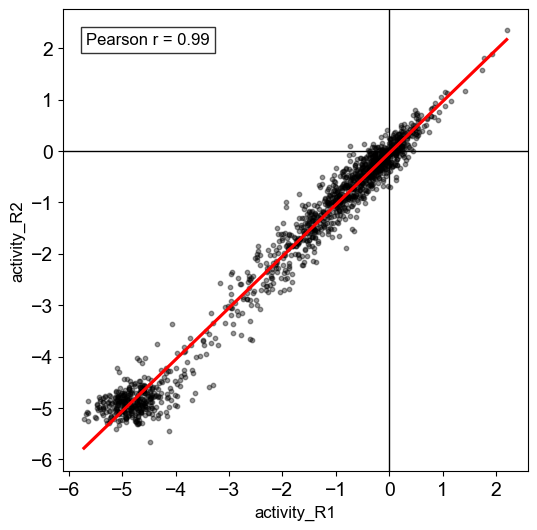

Total dots: 1180


In [12]:
data_type = 'activity'
the = 1
fig = replicate_scatter(df_Kan_input, data_type, the)
fig.savefig('./Figures/act_rep_' + str(the) + 'error.svg')
fig.savefig('./Figures/act_rep_' + str(the) + 'error.png')

plotly_fig, search_html = interactive_replicate_scatter(df_Kan_input, data_type, the)
plotly_fig.write_html('Figures/act_rep' + str(the) + 'error.html')

Number of total points: 952


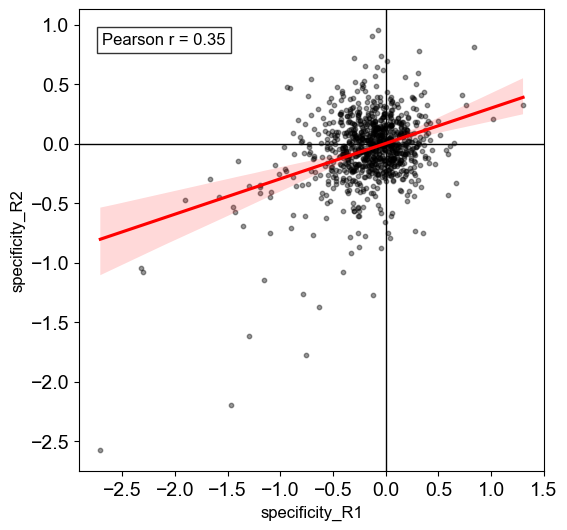

Total dots: 827


In [13]:
data_type = 'specificity'
the = 1
fig = replicate_scatter(df_Kan_Ara, data_type, the)
fig.savefig('./Figures/spe_rep_' + str(the) + 'error.svg')
fig.savefig('./Figures/spe_rep_' + str(the) + 'error.png')


plotly_fig, search_html = interactive_replicate_scatter(df_Kan_Ara, data_type, the)
plotly_fig.write_html('Figures/spe_rep' + str(the) + 'error.html')

list is created


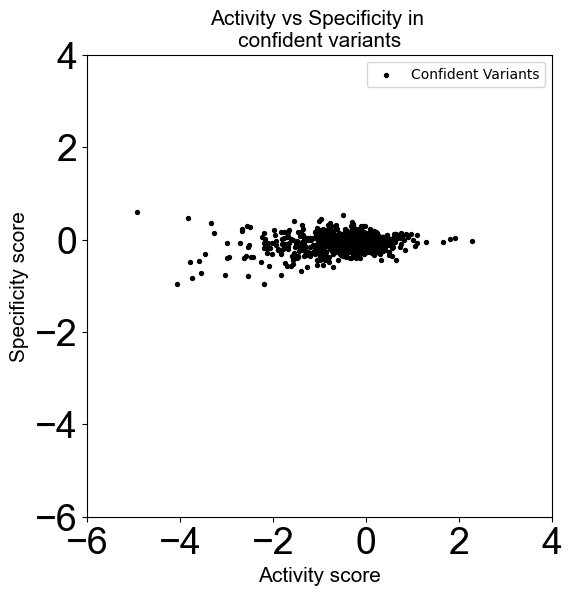

In [14]:
# Define colors for different numbers of mutations
the = 1 # Threshold for standard error
mult_variants_all = []  # List to store all multi-variant data
plt.figure(figsize=(6, 6))  # Create a new figure with specified size

filtered_Kan_input = df_Kan_input.drop_duplicates(subset=['AA_mut_list'])
filtered_Kan_Ara = df_Kan_Ara.drop_duplicates(subset=['AA_mut_list'])
# Filter the dataframe for rows with stderr less than the threshold and the specified number of mutations
indx = (filtered_Kan_input['stderr'] < the) & (filtered_Kan_input['AA_mut_list'] != "WT")
mult_variants = []  # List to store multi-variant data for the current number of mutations
print("list is created")

# Iterate over the filtered dataframe
for i in filtered_Kan_input[indx]['AA_mut_list']:
    try:
        # Check if the corresponding row in df_Kan_Ara has stderr less than the threshold
        if filtered_Kan_Ara[filtered_Kan_Ara['AA_mut_list'] == i]['stderr'].values[0] < the:
            # Extract activity and specificity values and their errors
            v_act = filtered_Kan_input[filtered_Kan_input['AA_mut_list'] == i]['activity'].values[0]
            v_spe = filtered_Kan_Ara[filtered_Kan_Ara['AA_mut_list'] == i]['specificity'].values[0]
            err_act = filtered_Kan_input[filtered_Kan_input['AA_mut_list'] == i]['stderr'].values[0]
            err_spe = filtered_Kan_Ara[filtered_Kan_Ara['AA_mut_list'] == i]['stderr'].values[0]
            # Append the data to the lists
            mult_variants.append([i, v_spe, v_act])
            mult_variants_all.append([i, v_spe, v_act, err_spe, err_act])
    except:
        pass

# Convert the list to a numpy array and plot the data
mult_variants = np.array(mult_variants, dtype=object)
plt.scatter(mult_variants[:, 2].astype(float), mult_variants[:, 1].astype(float),
            s=8, c='k', label='Confident Variants')

# Set plot labels and title
plt.ylabel('Specificity score', fontname='Arial',fontsize=15)
plt.xlabel('Activity score', fontname='Arial',fontsize=15)
plt.title('Activity vs Specificity in \nconfident variants', fontname='Arial',fontsize=15)
plt.xticks(np.arange(-6, 5, 2),fontname='Arial',fontsize=27)
plt.yticks(np.arange(-6, 5, 2),fontname='Arial',fontsize=27)
plt.legend()
# Save the plot as SVG and PNG
plt.savefig('./Figures/TnsB_Activity_vs_Specificity_' + str(the) + 'error.svg')

# Step 5. Interactive Heatmap

In [15]:
AA_refSeq= "NSQQNPDLAVHPLAIPMEGLLGESATTLEKNVIATQLSEEAQVKLEVIQSLLEPCDRTTYGQKLREAAEKLNVSLRTVQRLVKNWEQDGLVGLTQTSRADKGKHRIGEFWENFITKTYKEGNKGSKRMTPKQVALRVEAKARELKDSKPPNYKTVLRVLAPILEKQQKAKSIRSPGWRGTTLSVKTREGKDLSVDYSNHVWQCDHTRVDVLLVDQHGEILSRPWLTTVIDTYSRCIMGINLGFDAPSSGVVALALRHAILPKRYGSEYKLHCEWGTYGKPEHFYTDGGKDFRSNHLSQIGAQLGFVCHLRDRPSEGGVVERPFKTLNDQLFSTLPGYTGSNVQERPEDAEKDARLTLRELEQLLVRYIVDRYNQSIDARMGDQTRFERWEAGLPTVPVPIPERDLDICLMKQSRRTVQRGGCLQFQNLMYRGEYLAGYAGETVNLRFDPRDITTILVYRQENNQEVFLTRAHAQGLETEQLALDEAEAASRRLRTAGKTISNQSLLQEVVDRDALVATKKSRKERQKLEQTVLRSAAVDESNRESLPSQIVEPDEVESTETVHSQYEDIEVWDYEQLREEYGF"

def plot_enrichemnt_matrix(type,df_Ara_Kan_input_sm,AA_refSeq,error,minv,maxv,size,WT_value):
    # Define the range of positions
    start_position = 2
    end_position = 597

    single_letter_amino_acids = np.array(['*', 'C', 'P', 'G', #special
                                'I', 'V', 'L', 'F', 'M', 'A', 'W', #nonpolar
                                'Y', 'T', 'S', 'N', 'Q', #polar
                                'E', 'D', #negative
                                'H', 'K', 'R']) #positive

    #Mat mutations into matrix with enrichment values
    comparison_matrix=np.ones((len(single_letter_amino_acids),596))*np.nan
    stderrs=np.zeros((len(single_letter_amino_acids),596))*np.nan
    for i in df_Ara_Kan_input_sm.index:
        pos=df_Ara_Kan_input_sm['position'][i]
        mut=df_Ara_Kan_input_sm['AA_mut_list'][i]
        taa=mut[-1]
        hm_pos=np.where(single_letter_amino_acids==taa)[0][0]
        comparison_matrix[hm_pos,pos-2]=df_Ara_Kan_input_sm[type][i]
        stderrs[hm_pos,pos-2]=df_Ara_Kan_input_sm['stderr'][i]
    #Create markers for WT and no data
    markers = np.full(comparison_matrix.shape, '', dtype=object)
    for i in range(len(AA_refSeq)):
        taa=AA_refSeq[i]
        markers[np.where(single_letter_amino_acids==taa)[0][0],i] = '●'
        comparison_matrix[np.where(single_letter_amino_acids==taa)[0][0],i]=0
    comparison_matrix[:,0]
    customdata = []
    #Label hover data
    for i in range(len(single_letter_amino_acids)):
        row = []
        for j in range(start_position, end_position + 1):
            row.append(f"Position: {j}<br>Amino Acid: {single_letter_amino_acids[i]}<br>Enrichment Score: {comparison_matrix[i, j - start_position]}<br>StdErr: {stderrs[i, j - start_position]}")
        customdata.append(row)

    #Define markers for WT and No data
    markers = np.full(comparison_matrix.shape, '', dtype=object)
    markers[comparison_matrix == 0] = '●'
    print('# of positive values:',np.sum(comparison_matrix>0))

    cmap = sns.color_palette("RdBu_r", as_cmap=True)
    cmap.set_bad(color='grey')
    norm = TwoSlopeNorm(vmin=minv, vcenter=0, vmax=maxv)

    # Generate a Plotly-compatible colorscale
    n_bins = 256
    scalar_mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    scalar_mappable.set_array([])
    rgba_colors = scalar_mappable.to_rgba(np.linspace(norm.vmin, norm.vmax, n_bins))
    plotly_colorscale = [
        [i / (n_bins - 1), f"rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {a})"]
        for i, (r, g, b, a) in enumerate(rgba_colors)
    ]
    print("The Asymmetric colorscale is converted")
    #Create heatmap
    fig = go.Figure(data=go.Heatmap(
        z=comparison_matrix,
        x=list(range(start_position, end_position + 1)),
        y=single_letter_amino_acids,
        zmin=minv,zmax=maxv,
        colorscale=plotly_colorscale,
        customdata=customdata,
        text=markers,
        hovertemplate='%{customdata}<extra></extra>',
        colorbar=dict(title='Score',titlefont=dict(size=18), tickfont=dict(size=18)),
        texttemplate='%{text}',
        textfont=dict(color='black', size=10),
        xgap=0.5, ygap=0.5
    ))

    # Update layout to remove grid and adjust layout
    fig.update_layout(
        title=type+' TnsB',
        xaxis_title='Position',
        yaxis_title='Amino Acid',
        plot_bgcolor='rgba(0,0,0,0)',
        yaxis=dict(tickfont=dict(size=18),showticklabels=True,ticks='outside'),
        xaxis=dict(dtick=10,tickangle=300,tickfont=dict(size=16),showticklabels=True,ticks='outside'),
        width=size[0], height=size[1],
    )
    fig.show()
    return fig, comparison_matrix, stderrs

In [16]:
#Generate a single mutation dataframe
df_Kan_input_sm=df_Kan_input[df_Kan_input['AA_mut_list']!="WT"].copy()
df_Kan_input_sm['position'] = [int(''.join(list(i[1:-1]))) for i in df_Kan_input_sm['AA_mut_list']]
df_Kan_input_sm.replace(-np.inf, -10, inplace=True)
data_type='activity'
WT_value=0
size=(4000,700)
fig, activity, stderr_act = plot_enrichemnt_matrix(data_type, df_Kan_input_sm, AA_refSeq, True, -5, 3, size, WT_value)
fig.write_html(fig_dir + 'TnsB_heatmap_'+data_type+'.html')

# of positive values: 195
The Asymmetric colorscale is converted


In [17]:
#Generate a single mutation dataframe
df_Kan_Ara_sm=df_Kan_Ara[df_Kan_Ara['AA_mut_list']!="WT"].copy()
df_Kan_Ara_sm['position'] = [int(''.join(list(i[1:-1]))) for i in df_Kan_Ara_sm['AA_mut_list']]
df_Kan_Ara_sm.replace(-np.inf, -10, inplace=True)
size=(4000,700)
data_type = 'specificity'
fig, specificity, stderr_spec = plot_enrichemnt_matrix(data_type, df_Kan_Ara_sm, AA_refSeq, True, -2, 3, size, WT_value)
fig.write_html(fig_dir + 'TnsB_heatmap_'+data_type+'.html')

# of positive values: 384
The Asymmetric colorscale is converted


# Step 5-1. Non-interactive heatmap + Asymmetric colorscale (for manuscript)

In [18]:
AA_refSeq= "NSQQNPDLAVHPLAIPMEGLLGESATTLEKNVIATQLSEEAQVKLEVIQSLLEPCDRTTYGQKLREAAEKLNVSLRTVQRLVKNWEQDGLVGLTQTSRADKGKHRIGEFWENFITKTYKEGNKGSKRMTPKQVALRVEAKARELKDSKPPNYKTVLRVLAPILEKQQKAKSIRSPGWRGTTLSVKTREGKDLSVDYSNHVWQCDHTRVDVLLVDQHGEILSRPWLTTVIDTYSRCIMGINLGFDAPSSGVVALALRHAILPKRYGSEYKLHCEWGTYGKPEHFYTDGGKDFRSNHLSQIGAQLGFVCHLRDRPSEGGVVERPFKTLNDQLFSTLPGYTGSNVQERPEDAEKDARLTLRELEQLLVRYIVDRYNQSIDARMGDQTRFERWEAGLPTVPVPIPERDLDICLMKQSRRTVQRGGCLQFQNLMYRGEYLAGYAGETVNLRFDPRDITTILVYRQENNQEVFLTRAHAQGLETEQLALDEAEAASRRLRTAGKTISNQSLLQEVVDRDALVATKKSRKERQKLEQTVLRSAAVDESNRESLPSQIVEPDEVESTETVHSQYEDIEVWDYEQLREEYGF"

def asymmetric_seaborn_matrix(data_type, df_Ara_Kan_input_sm, AA_refSeq, error, minv, maxv, WT_value):
    # 표시할 범위 설정
    selected_ranges = [(29,37),(95, 108), (122, 134), (171, 185), (208, 228), (335, 357), (372, 386)]
    # 입력 데이터 필터링: 선택한 범위 내 position만 포함
    df_Ara_Kan_input_sm = df_Ara_Kan_input_sm[
        df_Ara_Kan_input_sm['position'].apply(
            lambda pos: any(start <= pos <= end for start, end in selected_ranges)
        )
    ]

    single_letter_amino_acids = np.array(['R', 'K', 'H', 'D', 'E',
                                'Q', 'N', 'S', 'T', 'Y', 'W', 'A',
                                'M', 'F', 'L', 'V', 'I',
                                'G', 'P',
                                'C', '*'])

    # 범위 처리 및 공백 추가
    valid_positions = []
    for start, end in selected_ranges:
        valid_positions.extend(range(start, end + 1))
        valid_positions.append(None)  # 범위 사이 공백용

    valid_positions = valid_positions[:-1]  # 마지막 공백 제거
    comparison_matrix = np.full((len(single_letter_amino_acids), len(valid_positions)), np.nan)
    stderrs = np.full((len(single_letter_amino_acids), len(valid_positions)), np.nan)

    position_to_index = {pos: idx for idx, pos in enumerate(valid_positions) if pos is not None}

    for i in df_Ara_Kan_input_sm.index:
        pos = df_Ara_Kan_input_sm['position'][i]
        mut = df_Ara_Kan_input_sm['AA_mut_list'][i]
        taa = mut[-1]
        hm_pos = np.where(single_letter_amino_acids == taa)[0][0]
        if pos in position_to_index and df_Ara_Kan_input_sm['stderr'][i]:
            comparison_matrix[hm_pos, position_to_index[pos]] = df_Ara_Kan_input_sm[data_type][i]

    markers = np.full(comparison_matrix.shape, '', dtype=object)
    for i in range(len(AA_refSeq)):
        pos = i + 2
        if pos in position_to_index:
            taa = AA_refSeq[i]
            aa_index = np.where(single_letter_amino_acids == taa)[0][0]
            markers[aa_index, position_to_index[pos]] = '●'
            comparison_matrix[aa_index, position_to_index[pos]] = 0
    print('# of positive values:', np.sum(comparison_matrix >= 0.01))

    x_labels = [pos if pos is not None else "" for pos in valid_positions]
    y_labels = single_letter_amino_acids
    cmap = sns.color_palette("RdBu_r", as_cmap=True)
    cmap.set_bad(color='grey')

    norm = mcolors.TwoSlopeNorm(vmin=minv, vcenter=0, vmax=maxv)
    
    fig = plt.figure(figsize=(50, 30))
    sns.heatmap(
        comparison_matrix,
        cmap=cmap,
        norm=norm,
        xticklabels=x_labels,
        yticklabels=y_labels,
        annot=False,
        fmt=".2f",
        square=True,
        linewidths=0.4,
        linecolor='black',
        cbar_kws={'label': 'Score', 'shrink': 0.5}
    )

    plt.yticks(rotation=0, fontsize=17, fontname='Arial')
    plt.xticks(rotation=90,
    ticks=[i + 0.5 for i, pos in enumerate(valid_positions) if pos is not None and pos % 5 == 0],
    labels=[pos for pos in valid_positions if pos is not None and pos % 5 == 0],
    fontsize=40, fontname='Arial'
)
    num_rows, num_cols = comparison_matrix.shape
    for i in range(num_rows):
        for j in range(num_cols):
            if comparison_matrix[i, j] == 0:
                plt.plot(j + 0.5, i + 0.5, 'k.', markersize=10)

    plt.tight_layout()
    plt.show()

    return fig, comparison_matrix, stderrs


# of positive values: 190


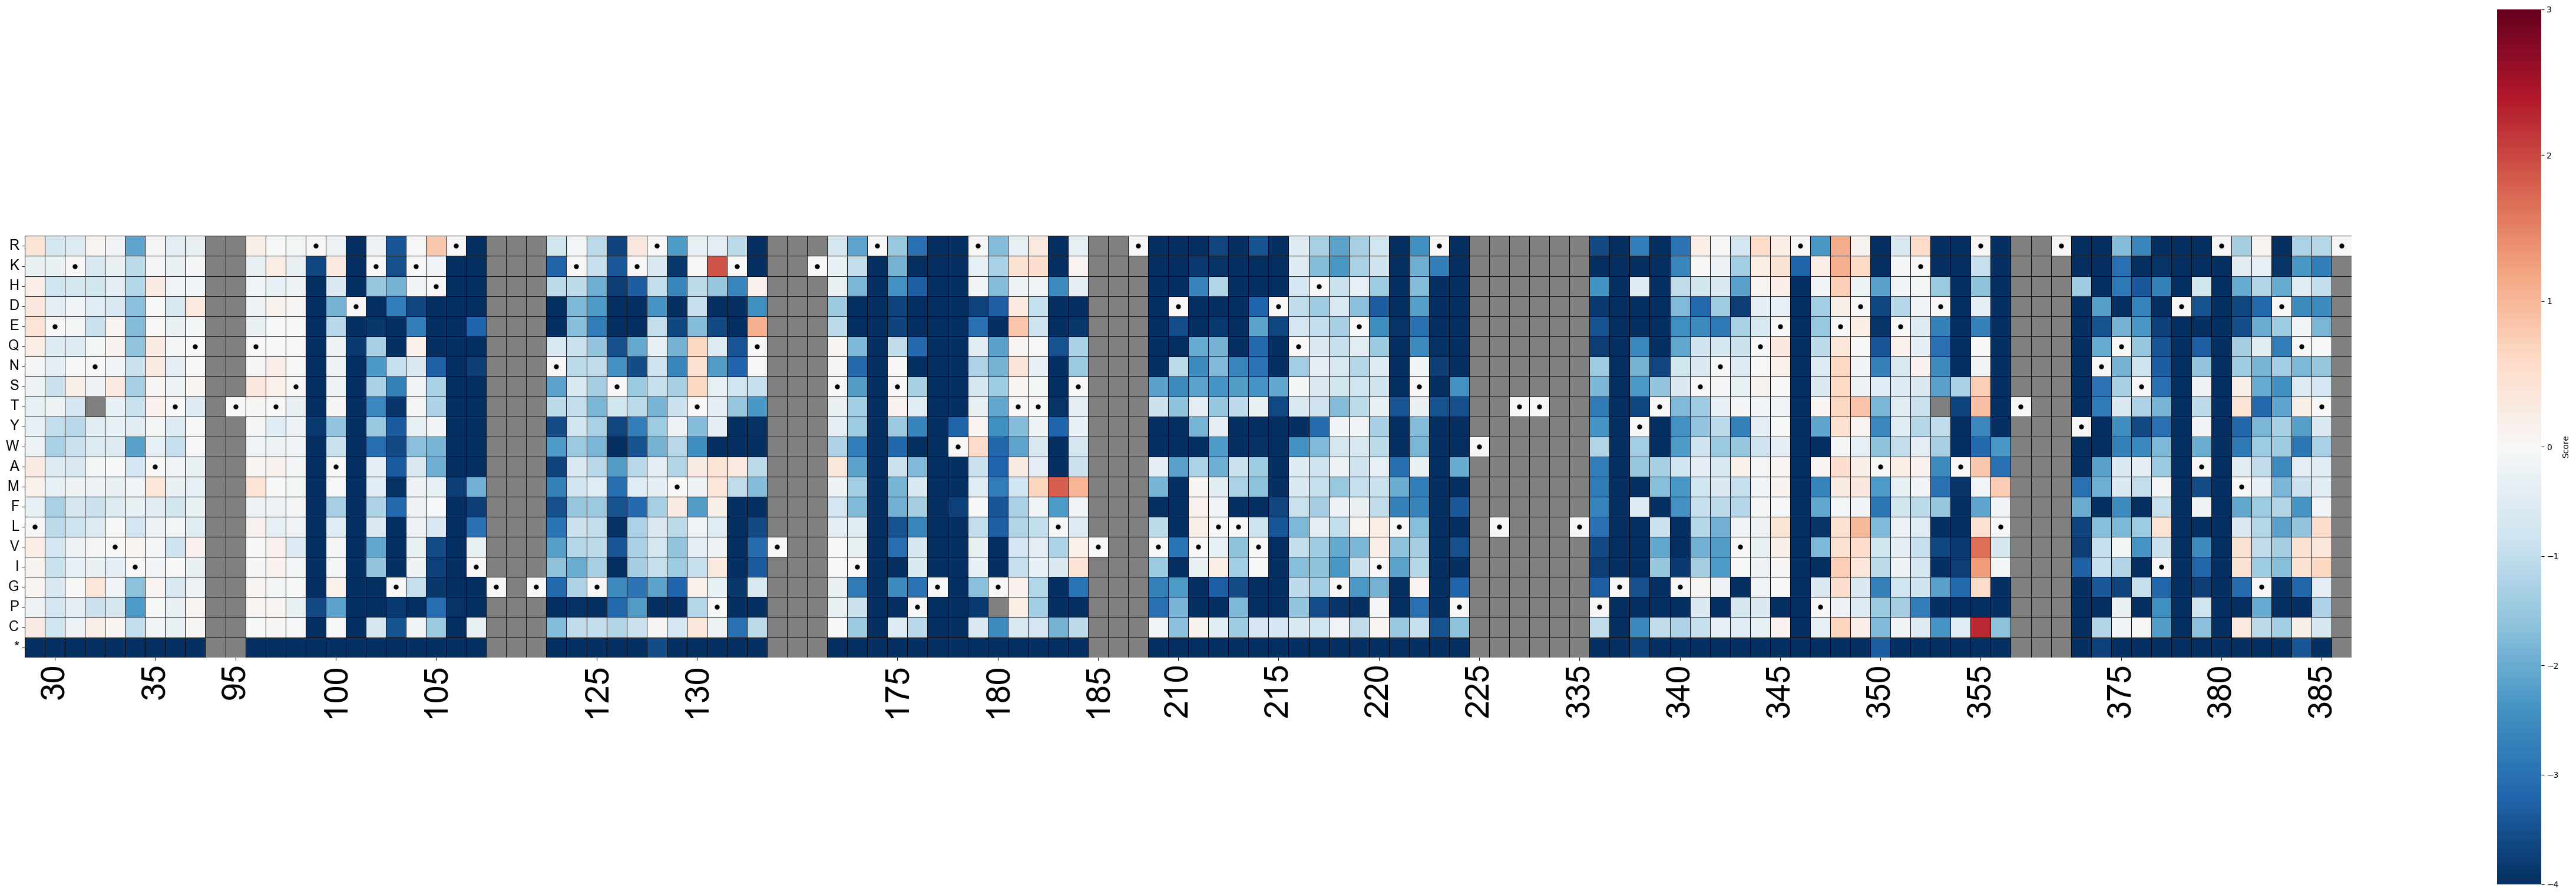

File has been saved


In [19]:
#Activity Heatmap
maxcolor = 3
mincolor = -4
df_Kan_input_sm=df_Kan_input[df_Kan_input['AA_mut_list']!="WT"].copy()
df_Kan_input_sm['position'] = [int(''.join(list(i[1:-1]))) for i in df_Kan_input_sm['AA_mut_list']]
df_Kan_input_sm.replace(-np.inf, -10, inplace=True)
data_type = 'activity'
WT_value=0
fig, activity, stderr_act = asymmetric_seaborn_matrix(data_type, df_Kan_input_sm, AA_refSeq, True, mincolor, maxcolor, WT_value)
#fig.savefig(fig_dir + 'TnsB_' + data_type + '(3-5)_30.svg', format='svg')
print('File has been saved')

# of positive values: 353


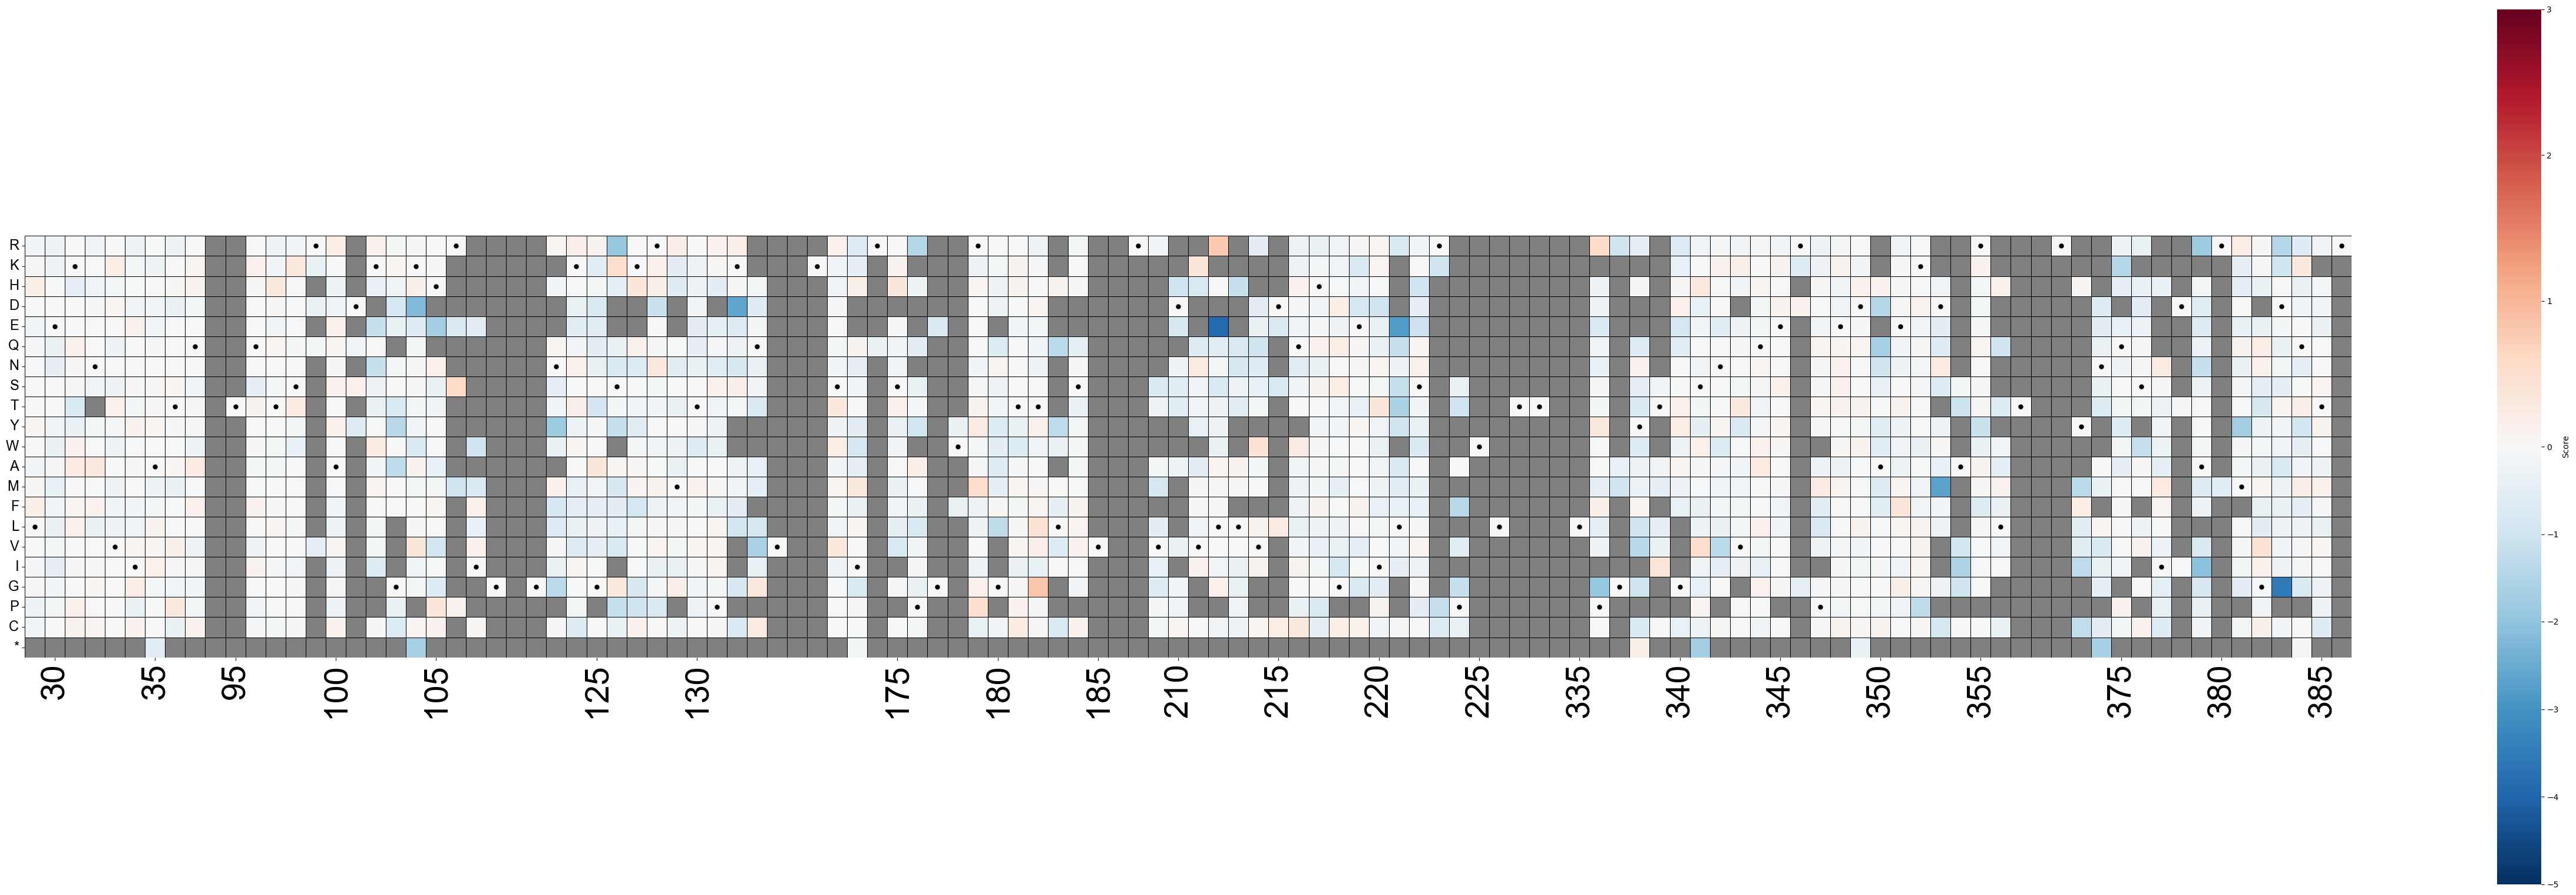

File has been saved


In [20]:
#Specificity Heatmap
maxcolor = 3
mincolor = -5
df_Kan_Ara_sm=df_Kan_Ara[df_Kan_Ara['AA_mut_list']!="WT"].copy()
df_Kan_Ara_sm['position'] = [int(''.join(list(i[1:-1]))) for i in df_Kan_Ara_sm['AA_mut_list']]
df_Kan_Ara_sm.replace(-np.inf, -10, inplace=True)
data_type = 'specificity'
fig, specificity, stderr_spec = asymmetric_seaborn_matrix(data_type, df_Kan_Ara_sm, AA_refSeq, True, mincolor, maxcolor, WT_value)
fig.savefig(fig_dir + 'TnsB_' + data_type + '(3-5).svg', format='svg')
print('File has been saved')

In [21]:
def mut_in_context(df,suffixes,mutation,style):
    """
    Plots the enrichment score of a specific mutation in the context of wild-type synonymous mutations.

    Parameters:
    df (DataFrame): DataFrame containing mutation and sequence data.
    suffixes (tuple): Suffixes to apply to overlapping column names in the resulting DataFrame.
    mutation (str): The specific mutation to highlight in the plot.
    style (str): The style of the plot, specifying which column to use for the x-axis.
    """
    mut=mutation
    fig=plt.figure(figsize=(3,2.5))
    ax=fig.add_subplot(111)
    ax.set_title(mut+' '+style+' in\ncontext of WT syn mut')
    kernel = stats.gaussian_kde(df[df['AA_mut_list']=='WT']['enrich'+suffixes[1]])

    sub_df=df[df['AA_mut_list']==mut]
    ax.errorbar(sub_df[style].values[0],[0.4],xerr=sub_df['stderr'].values[0],capsize=5,color='k',barsabove=False)
    ax.scatter(sub_df['enrich'+suffixes[0]],np.zeros(len(sub_df))+0.4,c='k',s=5)
    ax.scatter(sub_df['enrich'+suffixes[1]],np.zeros(len(sub_df))+0.4,c='k',s=5)
    scatter=ax.scatter(sub_df[style].values[0],[0.4],c='white',edgecolor='k')
    x=np.linspace(-5,5,50)
    ax.plot(x,kernel(x)/4,color='k')
    ax.plot(x,-kernel(x)/4,color='k')
    ax.fill_between(x,kernel(x)/4,-kernel(x)/4,edgecolor='gray',facecolor='gray')

    ax.set_xlabel('Score')
    ax.set_yticks([])
    ax.set_ylim([-0.3,0.8])
    return fig

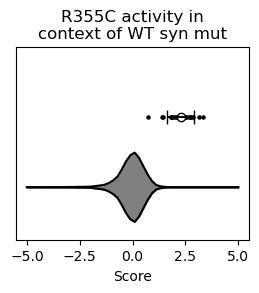

In [22]:
fig = mut_in_context(df_Kan_input,['_Kan_R1','_Kan_R2'],'R355C','activity')

# Step 6. Compute Frustration Profile

In [24]:
import frustratometer
import matplotlib.pylab as plt
import numpy as np
import mdtraj as md
from scipy.stats import mannwhitneyu

In [25]:
missing_res=[1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,516,517,518,519,520,521,522,523,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584]
dict_res={}
c=0
for i in range(1,585):
    if not i in missing_res:
        dict_res[i]=c
        c=c+1
print(dict_res)

{31: 0, 32: 1, 33: 2, 34: 3, 35: 4, 36: 5, 37: 6, 38: 7, 39: 8, 40: 9, 41: 10, 42: 11, 43: 12, 44: 13, 45: 14, 46: 15, 47: 16, 48: 17, 49: 18, 50: 19, 51: 20, 52: 21, 53: 22, 54: 23, 55: 24, 56: 25, 57: 26, 58: 27, 59: 28, 60: 29, 61: 30, 62: 31, 63: 32, 64: 33, 65: 34, 66: 35, 67: 36, 68: 37, 69: 38, 70: 39, 71: 40, 72: 41, 73: 42, 74: 43, 75: 44, 76: 45, 77: 46, 78: 47, 79: 48, 80: 49, 81: 50, 82: 51, 83: 52, 84: 53, 85: 54, 86: 55, 87: 56, 88: 57, 89: 58, 90: 59, 91: 60, 92: 61, 93: 62, 94: 63, 95: 64, 96: 65, 97: 66, 98: 67, 99: 68, 100: 69, 101: 70, 102: 71, 103: 72, 104: 73, 105: 74, 106: 75, 107: 76, 108: 77, 109: 78, 110: 79, 111: 80, 112: 81, 113: 82, 114: 83, 115: 84, 116: 85, 117: 86, 118: 87, 119: 88, 120: 89, 121: 90, 122: 91, 123: 92, 124: 93, 125: 94, 126: 95, 127: 96, 128: 97, 129: 98, 130: 99, 131: 100, 132: 101, 133: 102, 134: 103, 135: 104, 136: 105, 137: 106, 138: 107, 139: 108, 140: 109, 141: 110, 142: 111, 143: 112, 144: 113, 145: 114, 146: 115, 147: 116, 148: 117

In [26]:
# Define the path to your PDB file
pdb_path = '../8rdu/8rdu_TnsB(R_others2).pdb'
offset_TNSB=3
AA=list('-ACDEFGHIKLMNPQRSTVWY')
structure = frustratometer.Structure.full_pdb(pdb_path)
print(len(structure.sequence),structure.sequence)
## Single residue frustration with electrostatics
AWSEM_model = frustratometer.AWSEM(structure,distance_cutoff_contact=9.5) 
native_frust=AWSEM_model.frustration(kind='singleresidue')

@> 7579 atoms and 1 coordinate set(s) were parsed in 0.05s.
/Users/edoderor/anaconda3/envs/pbase/lib/python3.10/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning:

Ignoring unrecognized record 'END' at line 7586

@> 7579 atoms and 1 coordinate set(s) were parsed in 0.03s.


949 KNVIATQLSEEAQVKLEVIQSLLEPCDRTTYGQKLREAAEKLNVSLRTVQRLVKNWEQDGLVGLTQTSRADKGKHRIGEFWENFITKTYKEGNKGSKRMTPKQVALRVEAKARELKDSKPPNYKTVLRVLAPILEKQQKAKSIRSPGWRGTTLSVKTREGKDLSVDYSNHVWQCDHTRVDVLLVDQHGEILSRPWLTTVIDTYSRCIMGINLGFDAPSSGVVALALRHAILPKRYGSEYKLHCEWGTYGKPEHFYTDGGKDFRSNHLSQIGAQLGFVCHLRDRPSEGGVVERPFKTLNDQLFSTLPGYTGSNVQERPEDAEKDARLTLRELEQLLVRYIVDRYNQSIDARMGDQTRFERWEAGLPTVPVPIPERDLDICLMKQSRRTVQRGGCLQFQNLMYRGEYLAGYAGETVNLRFDPRDITTILVYRQENNQEVFLTRAHAQGLETEQLALDEAEAASRRLRTAGKTISNQSLLQEVVDRDAKERQKLEQTVLRSAAVDESKGTWKSCRVVGETGKALTDRLDAVIKRDEQVLERFRAHLRFGKLSGEDFKEWMPSSNSKEMLRILTSATEGYSGLDSVLHEDAKRDVSSLSGYIKGKSIPLRVGESRTGTDRLDAVIKRDRFETTYKEGNKGSKRMTKQLNYKQAKSIRSPGWRGTTLSVKTEGKDLSVDYSDHRVDVLVIDYSRCIKLHCEYDRPSEGGVVERPFKTLNDQLFSTLPGYTGSNVQERPEDAEKDARLLLLVRYIVDRYNQSIDARMGDQTRFERWEAGLPTVPVLMLESAGSNLLDLLVDQHGEILSPEHSNHLSQIGAQLGFVCHLRTDARLTIPERDLDICLMKQSRRTVQRGGCLQFQNLMYRGEYLAGYAGETVNLRFPDITTILVYRQENNQEVFLTRAHAQGLETEQLALDEAEAASRRLRTAGKTISNQSLLQEVVDRDALVATKKS


In [27]:
df_tmp=df_Kan_input.drop_duplicates(subset=['AA_mut_list'])
indx=(df_tmp['stderr']<1)
mult_variants=[]
for i in df_tmp[indx]['AA_mut_list']:
    try:
        v_act=df_tmp[df_tmp['AA_mut_list']==i]['activity'].values[0]
        mult_variants.append([i,v_act])
    except:
        pass
mult_variants=np.array(mult_variants,dtype=object)
top_p=mult_variants[mult_variants[:,1]>0.5,0]
N=len(top_p)
bottom_p=[i[0] for i in mult_variants[np.argsort(mult_variants[:,1])][:N]]

Q133E
PKQVA
PKEVA
E348H
RPEDA
RPHDA
E348S
RPEDA
RPSDA
K352R
AEKDA
AERDA
D349V
PEDAE
PEVAE
R355T
DARLT
DATLT
E348C
RPEDA
RPCDA
D349K
PEDAE
PEKAE
R355A
DARLT
DAALT
D349L
PEDAE
PELAE
D349T
PEDAE
PETAE
P131K
MTPKQ
MTKKQ
T182K
GTTLS
GTKLS
Q344R
NVQER
NVRER
E348K
RPEDA
RPKDA
E348I
RPEDA
RPIDA
R355C
DARLT
DACLT
T181E
RGTTL
RGETL
R355V
DARLT
DAVLT
T130Q
RMTPK
RMQPK
S184M
TLSVK
TLMVK
H105R
GKHRI
GKRRI
E348R
RPEDA
RPRDA
T130S
RMTPK
RMSPK
T385L
DQTRF
DQLRF
R179W
GWRGT
GWWGT
R355G
DARLT
DAGLT
E348T
RPEDA
RPTDA
L183M
TTLSV
TTMSV
R355I
DARLT
DAILT
L356M
ARLTL
ARMTL
T182M
GTTLS
GTMLS
T385I
DQTRF
DQIRF
R355S
DARLT
DASLT
E348N
RPEDA
RPNDA


(-7.0, 7.0)

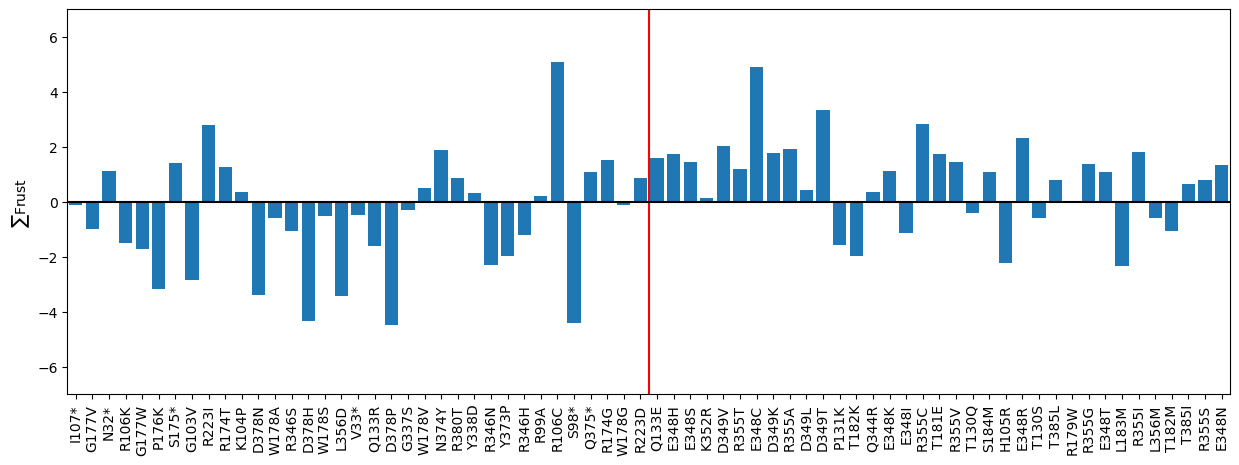

In [28]:
mut_list_b=bottom_p
diff_frust_b=[]
for mutation in mut_list_b:
    native_sequence=structure.sequence
    ind_mut=mutation.split('+')
    newseq=native_sequence
    for mut in ind_mut:
        gm = list(mut)
        gm = [gm[0],int(''.join(gm[1:-1])),gm[-1]]
        mut_position=dict_res[gm[1]]
        mut_aa=gm[2]
        newseq=newseq[:mut_position]+mut_aa+newseq[mut_position+1:]
    frustration_values=AWSEM_model.frustration(sequence=newseq,kind='singleresidue')
    diff_frust_b.append(np.sum(frustration_values-native_frust))

mut_list_g=top_p
diff_frust_g=[]
for mutation in mut_list_g:
    native_sequence=structure.sequence
    ind_mut=mutation.split('+')
    newseq=native_sequence
    for mut in ind_mut:
        gm = list(mut)
        gm = [gm[0],int(''.join(gm[1:-1])),gm[-1]]
        mut_position=dict_res[gm[1]]
        mut_aa=gm[2]
        print('='*40,'\n'+mut)
        print(newseq[mut_position-2:mut_position+3])
        newseq=newseq[:mut_position]+mut_aa+newseq[mut_position+1:]
        print(newseq[mut_position-2:mut_position+3])
    frustration_values=AWSEM_model.frustration(sequence=newseq,kind='singleresidue')
    diff_frust_g.append(np.sum(frustration_values-native_frust))

mut_list=np.concatenate([mut_list_b,mut_list_g])
diff_frust=np.concatenate([diff_frust_b,diff_frust_g])
plt.figure(figsize=(15,5))
plt.bar(mut_list,diff_frust)
plt.xticks(rotation=90)
plt.axvline(len(mut_list_b)-0.5,color='red')
plt.axhline(0,color='k')
plt.ylabel(r'$\sum \text{Frust}$')
plt.xlim([-0.5,len(mut_list)-0.5])
plt.ylim([-7,7])

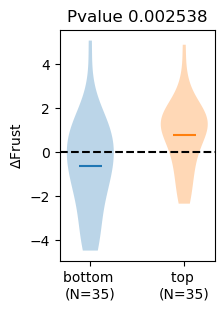

In [29]:
plt.figure(figsize=(2,3))
p=plt.violinplot([diff_frust[:N]],positions=[0],showmeans=True, showextrema=False)
p=plt.violinplot([diff_frust[N:]],positions=[1],showmeans=True, showextrema=False)
plt.xticks([0,1],['bottom \n(N='+str(N)+')','top \n(N='+str(N)+')'])
plt.ylabel(r'$\Delta \text{Frust}$')
#plt.legend(['high\nenrichment\nn='+str(N),'low\nenrichment\nn='+str(N)])
plt.axhline(0,color='k',linestyle='--')
plt.title('Pvalue '+str(np.round(mannwhitneyu(diff_frust[:N],diff_frust[N:])[1],6)))
plt.savefig('Figures/frust_violin_plot_tnsB.svg')